In [1]:
### If you are running on a CPU instance (e.g. a default lite/free plan of Watson Studio) 
### then pyTorch will not be installed by default and we need to install it, note this may
### take a few minutes to complete
try:
    import torch
except ImportError:
    !conda install pytorch-cpu -c pytorch

In [2]:
import argparse
import os, math
import io
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import requests
import warnings
import zipfile
import numpy as np

from matplotlib import pyplot as plt

from PIL import Image
from skimage.color import rgb2lab, lab2rgb, rgb2yuv, yuv2rgb

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device", device)

warnings.filterwarnings("ignore")

Device cpu


In [3]:
FACES_URL = "https://github.com/IBMDeveloperUK/Colourise-GAN-Workshop/raw/master/data/faces64_1000.zip"


training = 1
batch_size = 32
plot_batch_size = 4

lr = 1e-3
b1 = 0.5
b2 = 0.999
pixel_loss_weights = 100.0
n_epochs = 1

class rgb_img_data(Dataset):
    def __init__(self, url):
        r = requests.get(url)
        self.z = zipfile.ZipFile(io.BytesIO(r.content))
        self.files = self.z.namelist()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        filename = self.files[index]
        img = Image.open(self.z.open(filename))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        return img

class lab_img_data(Dataset):
    def __init__(self, rgb_img_gen):
        self.rgb_img_gen = rgb_img_gen

    def __len__(self):
        return len(self.rgb_img_gen)

    def __getitem__(self, index):
        img = self.rgb_img_gen[index]
        lab = rgb2lab(img)
        return lab
    
class tensor_img_data(Dataset):
    def __init__(self, lab_img_gen):
        self.lab_img_gen = lab_img_gen

    def __len__(self):
        return len(self.lab_img_gen)

    def __getitem__(self, index):
        lab = self.lab_img_gen[index]
        l = lab[...,0] / 50 - 1
        a_t = lab[...,1] / 128
        b_t = lab[...,2] / 128
        return torch.Tensor(np.expand_dims(l,axis=0)),torch.Tensor(np.stack([a_t,b_t],axis=0))

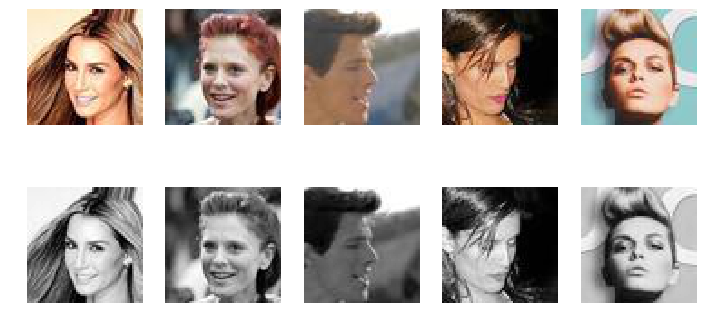

In [4]:
rgb_images = rgb_img_data(FACES_URL)
lab_images = lab_img_data(rgb_images)

n_samples = 5
plt.figure(figsize=[12,6])

for i in range(5):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    
    rgb_img = np.asarray(rgb_images[i])

    plt.imshow(rgb_img)

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')

    yuv_img = np.asarray(lab_images[i])

    plt.imshow(yuv_img[:,:,0], cmap='gray')
    
plt.show()



In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x, kernel_sz, stride, dialation):
    return max((math.ceil(x / stride) - 1) * stride + (kernel_sz - 1) * dialation + 1 - x, 0)

# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, kernel_sz, stride, dialation=(1, 1), value=0.):
    ih, iw = x.size()[-2:]
    pad_h, pad_w = get_same_padding(ih, kernel_sz[0], stride[0], dialation[0]), get_same_padding(iw, kernel_sz[1],
                                                                                                 stride[1],
                                                                                                 dialation[1])
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2], value=value)
    return x

class GeneratorEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, batch_norm=True, kernel_size=4):
        super(GeneratorEncoderBlock, self).__init__()

        layer_modules = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
        ]
        if batch_norm == True:
            layer_modules.append(nn.BatchNorm2d(out_channels))
        layer_modules.append(nn.LeakyReLU(negative_slope=0.2))
        self.encoder = nn.Sequential(*layer_modules)
        self.stride = stride
        self.kernel_size = kernel_size

    def forward(self, x):
        x = pad_same(x, kernel_sz=(self.kernel_size, self.kernel_size), stride=(self.stride, self.stride))
        return self.encoder(x)

class GeneratorDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, batch_norm=True, kernel_size=4, padding= 1):
        super(GeneratorDecoderBlock, self).__init__()
        layer_modules = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        ]
        if batch_norm == True:
            layer_modules.append(nn.BatchNorm2d(out_channels))
        layer_modules.append(nn.ReLU())
        self.decoder = nn.Sequential(*layer_modules)
        self.stride = stride
        self.kernel_size = kernel_size
        self.padding = padding

    def forward(self, x):
        x = self.decoder(x)
        return x

class Generator(nn.Module):
    def __init__(self, name, output_channels=2, training=True):
        super(Generator, self).__init__()
        self.name = name
        self.output_channels = output_channels
        self.training = training
        self.encoder_block_1 = GeneratorEncoderBlock(1, 64, 1)
        self.encoder_block_2 = GeneratorEncoderBlock(64, 64, 2)
        self.encoder_block_3 = GeneratorEncoderBlock(64, 128, 2)
        self.encoder_block_4 = GeneratorEncoderBlock(128, 256, 2)
        self.encoder_block_5 = GeneratorEncoderBlock(256, 512, 2)
        self.encoder_block_6 = GeneratorEncoderBlock(512, 512, 2)

        self.decoder_block_1 = GeneratorDecoderBlock(512, 512, 2)
        self.decoder_block_2 = GeneratorDecoderBlock(512, 256, 2)
        self.decoder_block_3 = GeneratorDecoderBlock(256, 128, 2)
        self.decoder_block_4 = GeneratorDecoderBlock(128, 64, 2)
        self.decoder_block_5 = GeneratorDecoderBlock(64, 64, 2)
        self.last_layer = nn.Conv2d(64, self.output_channels, kernel_size=1, stride=1)

    def forward(self, inputs):
        layers = []
        output = self.encoder_block_1(inputs)
        layers.append(output)
        output = self.encoder_block_2(output)
        layers.append(output)
        output = self.encoder_block_3(output)
        layers.append(output)
        output = self.encoder_block_4(output)
        layers.append(output)
        output = self.encoder_block_5(output)
        layers.append(output)
        output = self.encoder_block_6(output)
        layers.append(output)

        output = self.decoder_block_1(output)
        output = output + layers[len(layers) - 0 - 2]

        output = self.decoder_block_2(output)
        output = output + layers[len(layers) - 1 - 2]

        output = self.decoder_block_3(output)
        output = output + layers[len(layers) - 2 - 2]

        output = self.decoder_block_4(output)
        output = output + layers[len(layers) - 3 - 2]

        output = self.decoder_block_5(output)
        output = output + layers[len(layers) - 4 - 2]

        output = torch.tanh(self.last_layer(output))
        return output

class Discriminator(nn.Module):
    def __init__(self, name, training=True):
        super(Discriminator, self).__init__()
        self.name = name
        self.training = training
        self.discriminator_block_1 = GeneratorEncoderBlock(3, 64, 2, False)
        self.discriminator_block_2 = GeneratorEncoderBlock(64, 128, 2)
        self.discriminator_block_3 = GeneratorEncoderBlock(128, 256, 2)
        self.discriminator_block_4 = GeneratorEncoderBlock(256, 512, 2)
        self.last_layer = nn.Conv2d(512, 1, kernel_size=4, stride=1)

    def forward(self, inputs):
        output = self.discriminator_block_1(inputs)
        output = self.discriminator_block_2(output)
        output = self.discriminator_block_3(output)
        output = self.discriminator_block_4(output)
        output = torch.sigmoid(self.last_layer(output))
        return output

In [6]:
# Initialize generator and discriminator
generator = Generator('G', training=training).to(device)
discriminator = Discriminator('D', training=training).to(device)

# Loss function
bce_loss_with_logits = torch.nn.BCEWithLogitsLoss()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

rgb_images = rgb_img_data(FACES_URL)
lab_images = lab_img_data(rgb_images)
trainset = tensor_img_data(lab_images)
params = {'batch_size': 32,
          'shuffle': True,
          'drop_last': True,
          'num_workers': 16}
trainloader = DataLoader(trainset, **params)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr/10, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

# ----------
#  Training
# ----------
global_step = 0

for epoch in tqdm(range(n_epochs), total=n_epochs):
    g_losses = []
    d_losses = []
    for i, (l, ab) in tqdm(enumerate(trainloader), total=int(len(trainset) / batch_size)):
        # Adversarial ground truths
        valid = Variable(torch.Tensor(l.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.Tensor(l.size(0), 1).fill_(0.0), requires_grad=False).to(device)

        lvar = Variable(l).to(device)
        abvar = Variable(ab).to(device)
        real_imgs = torch.cat([lvar,abvar],dim=1)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        abgen = generator(lvar)

        gen_imgs = torch.cat([lvar.detach(),abgen],dim=1)

        # Loss measures generator's ability to fool the discriminator
        g_loss_gan = adversarial_loss(discriminator(gen_imgs.detach()), valid)
        g_loss = g_loss_gan + pixel_loss_weights * torch.mean((abvar-abgen)**2)

        g_losses.append(g_loss)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples

        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_losses.append(d_loss)
        d_loss.backward()
        optimizer_D.step()
        if i and (i + 1) % 50 == 0:
            print("Epoch: %d, Iter: %d,\tG loss: %.2f,\tD loss: %.2f" % (epoch, i + 1, g_loss.item(), d_loss.item()))

100%|██████████| 1/1 [08:59<00:00, 539.55s/it]]


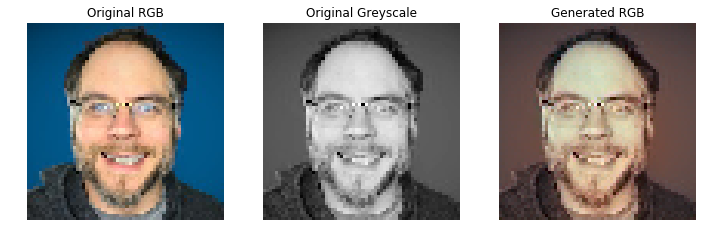

In [31]:
# Load a pretrained generator
if False:
    generator_url = "https://github.com/IBMDeveloperUK/Colourise-GAN-Workshop/raw/master/pretrained_models/generator.pth"
    r = requests.get(generator_url)
    device = torch.device('cpu')
    generator.load_state_dict(torch.load(io.BytesIO(r.content),
                                         map_location=device))

test_img_url = "https://github.com/IBMDeveloperUK/Colourise-GAN-Workshop/raw/master/data/matt_rgb.jpg"

r = requests.get(test_img_url)
test_img = np.asarray(Image.open(io.BytesIO(r.content)).resize((64,64)))

# Original RGB image
plt.figure(figsize=[12,6])
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Original RGB')
plt.imshow(test_img)

# Greyscale image
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Original Greyscale')
test_lab = rgb2lab(test_img)
plt.imshow(test_lab[:,:,0], cmap='gray')

# Generated image
test_inf = test_lab[...,0].reshape(1,1,64,64)
test_var = Variable(torch.Tensor(test_inf / 50 - 1)).to(device)
test_res = generator(test_var)
ab=test_res.cpu().detach().numpy()
ab[:,0,:,:] *= 128
ab[:,1,:,:] *= 128
gen_lab = np.concatenate([test_inf,ab],axis=1).reshape(3,64,64)
gen_rgb = lab2rgb(gen_lab.transpose(1,2,0))
gen_rgb = np.clip(gen_rgb, 0, 1)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Generated RGB')
plt.imshow(gen_rgb)

plt.show()